# Analytics Vidya - Football Hackathon
## by ABIR CHAKRABORTY ( mail2abirchakraborty@gmail.com)


### I have performed the Data exploring and analysis part in R - Studio some key findings i got from there was -
1. The Ratings are not uniformly distributed it needed to take care to prevent biasness towards higher score.
2. There are plenty of Null  and Zero columns which needs to be removed.
3. There are plenty of highly corelated columns  which needs to be removed.
4. The outliers of the numeric column should be treated.

### The Entire solution is divided in following parts
1. Building the first model by Catboost without encoding of the catagorical variables.
2. Building the second model by LGBM with encoding of the catagorical variables.
3. Take the average of the both result as they are expected to find patterns in different way.
4. Treatment of biasness towards highers ratings which is mainly due to presence of higher frequency of rating 10.

In [1]:
# Load the datasets

import pandas as pd
import numpy as np
import math as m

train = pd.read_csv("C:\\Users\\chakr\\Downloads\\train_1K0BDt5\\train.csv")
test = pd.read_csv("C:\\Users\\chakr\\Downloads\\test_kuhCxHY\\test.csv")
ss = pd.read_csv("C:\\Users\\chakr\\Downloads\\sample_submission_wBWLI0s.csv")

In [2]:
x_train = train.drop(['rating_num'], axis = 1)
x_test = test.copy()

In [3]:
# Replace winner,draw, loser with 1,0,-1 in winner column
# Replace team1 with 1 and team2 with zero in team column.

x_train['team'] = np.where(x_train['team']!= 'team1', 1, 0)
x_train['winner'] = np.where(x_train['winner']== 'winner', 1, np.where(x_train['winner']== 'loser', -1,0 ))

x_test['team'] = np.where(x_test['team']!= 'team1', 1, 0)
x_test['winner'] = np.where(x_test['winner']== 'winner', 1, np.where(x_test['winner']== 'loser', -1,0 ))

In [4]:
def remove_outliers(data):
    for col in data:
        high = data[col].mean() + 3*data[col].std()
        low = data[col].mean() - 3*data[col].std()
        data[col] = np.where(
            data[col] > high,
            high,
            np.where(
                data[col] < low,
                low,
                data[col]))
        
remove_outliers(x_train)
remove_outliers(x_test)

In [5]:
y_train = train['rating_num']

In [6]:
# Drop the row_id
all = pd.concat([x_train,x_test])
all = all.drop(['row_id'], axis = 1)

In [7]:
drop_cols = [
    'team2_other_raw_var_19','team1_other_raw_var_50','team1_other_raw_var_72','team1_other_raw_var_19',
    'team1_other_raw_var_31','team1_other_raw_var_33','team1_other_raw_var_92','team1_other_raw_var_82',
    'team2_other_raw_var_72','team1_other_raw_var_38','team1_other_raw_var_40','team1_other_raw_var_43',
    'team2_other_raw_var_92','team1_other_ratio_var_33','team1_other_ratio_var_32','team2_other_raw_var_82',
    'team2_other_raw_var_51','team2_other_raw_var_50','team2_other_raw_var_31','team1_other_raw_var_51',
    'team2_other_ratio_var_32','team2_other_raw_var_33','team2_other_ratio_var_33','team2_other_raw_var_38',
    'team2_other_raw_var_40','team2_other_raw_var_43','player_other_ratio_var_26','player_other_ratio_var_27',
    'player_other_ratio_var_24','player_other_ratio_var_28','player_other_ratio_var_25','player_other_ratio_var_23',
    'player_positional_ratio_var_79','player_other_ratio_var_37','player_defensive_ratio_var_38','player_defensive_ratio_var_39',
    'player_offensive_ratio_var_70','player_offensive_ratio_var_68','player_offensive_ratio_var_69','player_other_ratio_var_67',
    'player_other_ratio_var_73','player_offensive_ratio_var_77','player_other_ratio_var_36','player_defensive_ratio_var_16',
    'player_other_ratio_var_14','player_other_ratio_var_32','player_other_ratio_var_34','player_other_ratio_var_33',
    'player_offensive_ratio_var_72','player_positional_ratio_var_22','player_offensive_ratio_var_78','player_offensive_ratio_var_13',
    'player_other_ratio_var_66','player_offensive_ratio_var_40', 'player_other_ratio_var_7',]
all.drop(drop_cols, axis = 1, inplace = True)

In [8]:
cateogry_columns=all.select_dtypes(include=['object']).columns.tolist()
integer_columns=all.select_dtypes(include=['int64','float64']).columns.tolist()
len(cateogry_columns),len(integer_columns)

(0, 743)

In [9]:
# Replace the NUll values with mean
all = all.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x.fillna(x.mode()))

In [10]:
# Change the datatype of charecter columns as charecter.
all['scout_id'] = all['scout_id'].astype(str)
all['team1_system_id'] = all['team1_system_id'].astype(str)
all['team2_system_id'] = all['team2_system_id'].astype(str)
all['competitionId'] = all['competitionId'].astype(str)
all['player_position_1'] = all['player_position_1'].astype(str)
all['player_position_2'] = all['player_position_2'].astype(str)

In [11]:
cateogry_columns=all.select_dtypes(include=['object']).columns.tolist()
cateogry_columns

['scout_id',
 'competitionId',
 'player_position_1',
 'player_position_2',
 'team1_system_id',
 'team2_system_id']

In [12]:
# For next part - Encoded the catagorical columns
all2 = pd.get_dummies(all, drop_first=False)

In [13]:
x_train = all.iloc[0:20453,:]
x_test = all.iloc[20453:,:]

x_train.shape , x_test.shape

((20453, 743), (8774, 743))

In [14]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [15]:
# Drop few more poorly performing columns.

drop_cols = [
    'player_weight','player_offensive_derived_var_24',
 'player_offensive_derived_var_25',
 'player_other_derived_var_42',
 'player_offensive_derived_var_55',
 'player_offensive_derived_var_56',
 'player_positional_derived_var_64',
 'player_other_derived_var_76',
 'player_offensive_derived_var_89',
 'player_offensive_derived_var_90',
 'player_positional_derived_var_100',
 'player_other_derived_var_115',
 'player_offensive_derived_var_128',
 'player_positional_derived_var_136',
 'player_other_raw_var_142',
 'player_other_raw_var_184',
 'player_offensive_derived_var_153',
 'player_offensive_derived_var_151']

x_train.drop(drop_cols, axis = 1, inplace = True)
x_test.drop(drop_cols, axis = 1, inplace = True)


C:\Users\chakr\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# 1st Model -  Catboost without encoding of catagorical variables.

In [16]:
from catboost import CatBoostRegressor, Pool
categorical_features =  np.where(x_train.dtypes == object )[0]

model = CatBoostRegressor(iterations=5000)
model.fit(x_train, y_train, cat_features=categorical_features)
test_pred = model.predict(x_test)

ss['rating_num'] = test_pred
#ss.to_csv('football2.csv',index=False)

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)[-20:]


Learning rate set to 0.017824
0:	learn: 1.8494765	total: 271ms	remaining: 22m 34s
1:	learn: 1.8465509	total: 397ms	remaining: 16m 32s
2:	learn: 1.8438017	total: 528ms	remaining: 14m 40s
3:	learn: 1.8409946	total: 669ms	remaining: 13m 56s
4:	learn: 1.8384416	total: 801ms	remaining: 13m 20s
5:	learn: 1.8361308	total: 905ms	remaining: 12m 33s
6:	learn: 1.8335682	total: 1.01s	remaining: 11m 58s
7:	learn: 1.8311454	total: 1.11s	remaining: 11m 35s
8:	learn: 1.8289311	total: 1.21s	remaining: 11m 8s
9:	learn: 1.8267622	total: 1.29s	remaining: 10m 42s
10:	learn: 1.8244924	total: 1.38s	remaining: 10m 27s
11:	learn: 1.8220956	total: 1.49s	remaining: 10m 19s
12:	learn: 1.8198384	total: 1.57s	remaining: 10m 3s
13:	learn: 1.8176486	total: 1.67s	remaining: 9m 56s
14:	learn: 1.8155748	total: 1.76s	remaining: 9m 45s
15:	learn: 1.8133377	total: 1.86s	remaining: 9m 38s
16:	learn: 1.8113641	total: 1.96s	remaining: 9m 34s
17:	learn: 1.8093810	total: 2.05s	remaining: 9m 27s
18:	learn: 1.8073791	total: 2.14s

158:	learn: 1.6930909	total: 15.8s	remaining: 8m 1s
159:	learn: 1.6927001	total: 15.9s	remaining: 8m
160:	learn: 1.6921729	total: 16s	remaining: 8m
161:	learn: 1.6917844	total: 16.1s	remaining: 8m
162:	learn: 1.6913767	total: 16.2s	remaining: 8m
163:	learn: 1.6910075	total: 16.3s	remaining: 8m
164:	learn: 1.6903911	total: 16.4s	remaining: 8m
165:	learn: 1.6899521	total: 16.5s	remaining: 8m
166:	learn: 1.6896008	total: 16.6s	remaining: 8m
167:	learn: 1.6892288	total: 16.7s	remaining: 7m 59s
168:	learn: 1.6889038	total: 16.8s	remaining: 7m 59s
169:	learn: 1.6884140	total: 16.9s	remaining: 7m 59s
170:	learn: 1.6878959	total: 16.9s	remaining: 7m 58s
171:	learn: 1.6874632	total: 17s	remaining: 7m 58s
172:	learn: 1.6871605	total: 17.1s	remaining: 7m 57s
173:	learn: 1.6867897	total: 17.2s	remaining: 7m 57s
174:	learn: 1.6865366	total: 17.3s	remaining: 7m 56s
175:	learn: 1.6862155	total: 17.4s	remaining: 7m 56s
176:	learn: 1.6858155	total: 17.5s	remaining: 7m 56s
177:	learn: 1.6855055	total: 1

315:	learn: 1.6408887	total: 30.3s	remaining: 7m 28s
316:	learn: 1.6405934	total: 30.4s	remaining: 7m 28s
317:	learn: 1.6403598	total: 30.4s	remaining: 7m 28s
318:	learn: 1.6399027	total: 30.5s	remaining: 7m 27s
319:	learn: 1.6395846	total: 30.6s	remaining: 7m 27s
320:	learn: 1.6392869	total: 30.7s	remaining: 7m 27s
321:	learn: 1.6389790	total: 30.8s	remaining: 7m 27s
322:	learn: 1.6386242	total: 30.9s	remaining: 7m 27s
323:	learn: 1.6384299	total: 31s	remaining: 7m 27s
324:	learn: 1.6382678	total: 31.1s	remaining: 7m 27s
325:	learn: 1.6379504	total: 31.2s	remaining: 7m 26s
326:	learn: 1.6377127	total: 31.2s	remaining: 7m 26s
327:	learn: 1.6374227	total: 31.3s	remaining: 7m 26s
328:	learn: 1.6370934	total: 31.4s	remaining: 7m 26s
329:	learn: 1.6366604	total: 31.5s	remaining: 7m 26s
330:	learn: 1.6364103	total: 31.6s	remaining: 7m 26s
331:	learn: 1.6360895	total: 31.7s	remaining: 7m 25s
332:	learn: 1.6359033	total: 31.8s	remaining: 7m 25s
333:	learn: 1.6356428	total: 31.9s	remaining: 7m

471:	learn: 1.6028786	total: 44.4s	remaining: 7m 5s
472:	learn: 1.6026139	total: 44.5s	remaining: 7m 5s
473:	learn: 1.6024335	total: 44.6s	remaining: 7m 5s
474:	learn: 1.6021219	total: 44.7s	remaining: 7m 5s
475:	learn: 1.6019387	total: 44.8s	remaining: 7m 5s
476:	learn: 1.6015831	total: 44.9s	remaining: 7m 5s
477:	learn: 1.6014050	total: 44.9s	remaining: 7m 5s
478:	learn: 1.6011269	total: 45s	remaining: 7m 5s
479:	learn: 1.6008205	total: 45.1s	remaining: 7m 4s
480:	learn: 1.6003950	total: 45.2s	remaining: 7m 4s
481:	learn: 1.6002106	total: 45.3s	remaining: 7m 4s
482:	learn: 1.5999800	total: 45.4s	remaining: 7m 4s
483:	learn: 1.5996395	total: 45.5s	remaining: 7m 4s
484:	learn: 1.5993338	total: 45.6s	remaining: 7m 4s
485:	learn: 1.5989797	total: 45.7s	remaining: 7m 4s
486:	learn: 1.5988303	total: 45.7s	remaining: 7m 3s
487:	learn: 1.5986749	total: 45.8s	remaining: 7m 3s
488:	learn: 1.5984188	total: 45.9s	remaining: 7m 3s
489:	learn: 1.5981608	total: 46s	remaining: 7m 3s
490:	learn: 1.59

630:	learn: 1.5605544	total: 58.7s	remaining: 6m 46s
631:	learn: 1.5601160	total: 58.8s	remaining: 6m 46s
632:	learn: 1.5597901	total: 58.9s	remaining: 6m 46s
633:	learn: 1.5595245	total: 59s	remaining: 6m 46s
634:	learn: 1.5591910	total: 59.1s	remaining: 6m 46s
635:	learn: 1.5590225	total: 59.2s	remaining: 6m 46s
636:	learn: 1.5587117	total: 59.3s	remaining: 6m 46s
637:	learn: 1.5584680	total: 59.4s	remaining: 6m 46s
638:	learn: 1.5582450	total: 59.5s	remaining: 6m 46s
639:	learn: 1.5577890	total: 59.6s	remaining: 6m 45s
640:	learn: 1.5574805	total: 59.7s	remaining: 6m 45s
641:	learn: 1.5572612	total: 59.8s	remaining: 6m 45s
642:	learn: 1.5570067	total: 59.9s	remaining: 6m 45s
643:	learn: 1.5567516	total: 60s	remaining: 6m 45s
644:	learn: 1.5564222	total: 1m	remaining: 6m 45s
645:	learn: 1.5560997	total: 1m	remaining: 6m 45s
646:	learn: 1.5559295	total: 1m	remaining: 6m 45s
647:	learn: 1.5555876	total: 1m	remaining: 6m 45s
648:	learn: 1.5553651	total: 1m	remaining: 6m 45s
649:	learn: 

787:	learn: 1.5184236	total: 1m 13s	remaining: 6m 31s
788:	learn: 1.5180949	total: 1m 13s	remaining: 6m 31s
789:	learn: 1.5179032	total: 1m 13s	remaining: 6m 31s
790:	learn: 1.5175458	total: 1m 13s	remaining: 6m 31s
791:	learn: 1.5173393	total: 1m 13s	remaining: 6m 31s
792:	learn: 1.5170746	total: 1m 13s	remaining: 6m 31s
793:	learn: 1.5168079	total: 1m 13s	remaining: 6m 31s
794:	learn: 1.5165717	total: 1m 13s	remaining: 6m 31s
795:	learn: 1.5162590	total: 1m 14s	remaining: 6m 30s
796:	learn: 1.5160313	total: 1m 14s	remaining: 6m 30s
797:	learn: 1.5157357	total: 1m 14s	remaining: 6m 30s
798:	learn: 1.5155406	total: 1m 14s	remaining: 6m 30s
799:	learn: 1.5152475	total: 1m 14s	remaining: 6m 30s
800:	learn: 1.5149819	total: 1m 14s	remaining: 6m 30s
801:	learn: 1.5147680	total: 1m 14s	remaining: 6m 30s
802:	learn: 1.5145391	total: 1m 14s	remaining: 6m 30s
803:	learn: 1.5142461	total: 1m 14s	remaining: 6m 30s
804:	learn: 1.5140558	total: 1m 14s	remaining: 6m 30s
805:	learn: 1.5137455	total:

939:	learn: 1.4819416	total: 1m 27s	remaining: 6m 16s
940:	learn: 1.4817302	total: 1m 27s	remaining: 6m 16s
941:	learn: 1.4814714	total: 1m 27s	remaining: 6m 16s
942:	learn: 1.4812475	total: 1m 27s	remaining: 6m 16s
943:	learn: 1.4810705	total: 1m 27s	remaining: 6m 16s
944:	learn: 1.4808786	total: 1m 27s	remaining: 6m 16s
945:	learn: 1.4806578	total: 1m 27s	remaining: 6m 16s
946:	learn: 1.4803790	total: 1m 27s	remaining: 6m 16s
947:	learn: 1.4801337	total: 1m 28s	remaining: 6m 16s
948:	learn: 1.4798878	total: 1m 28s	remaining: 6m 16s
949:	learn: 1.4796756	total: 1m 28s	remaining: 6m 15s
950:	learn: 1.4794113	total: 1m 28s	remaining: 6m 15s
951:	learn: 1.4792115	total: 1m 28s	remaining: 6m 15s
952:	learn: 1.4790540	total: 1m 28s	remaining: 6m 15s
953:	learn: 1.4788304	total: 1m 28s	remaining: 6m 15s
954:	learn: 1.4786411	total: 1m 28s	remaining: 6m 15s
955:	learn: 1.4784037	total: 1m 28s	remaining: 6m 15s
956:	learn: 1.4781452	total: 1m 28s	remaining: 6m 15s
957:	learn: 1.4778816	total:

1093:	learn: 1.4488072	total: 1m 41s	remaining: 6m 1s
1094:	learn: 1.4486358	total: 1m 41s	remaining: 6m 1s
1095:	learn: 1.4484759	total: 1m 41s	remaining: 6m 1s
1096:	learn: 1.4482831	total: 1m 41s	remaining: 6m 1s
1097:	learn: 1.4481078	total: 1m 41s	remaining: 6m 1s
1098:	learn: 1.4478511	total: 1m 41s	remaining: 6m
1099:	learn: 1.4476631	total: 1m 41s	remaining: 6m
1100:	learn: 1.4474006	total: 1m 41s	remaining: 6m
1101:	learn: 1.4472485	total: 1m 41s	remaining: 6m
1102:	learn: 1.4470930	total: 1m 42s	remaining: 6m
1103:	learn: 1.4468200	total: 1m 42s	remaining: 6m
1104:	learn: 1.4466610	total: 1m 42s	remaining: 6m
1105:	learn: 1.4464354	total: 1m 42s	remaining: 6m
1106:	learn: 1.4461747	total: 1m 42s	remaining: 6m
1107:	learn: 1.4460199	total: 1m 42s	remaining: 6m
1108:	learn: 1.4457835	total: 1m 42s	remaining: 5m 59s
1109:	learn: 1.4455871	total: 1m 42s	remaining: 5m 59s
1110:	learn: 1.4453901	total: 1m 42s	remaining: 5m 59s
1111:	learn: 1.4451923	total: 1m 42s	remaining: 5m 59s


1243:	learn: 1.4192913	total: 1m 54s	remaining: 5m 46s
1244:	learn: 1.4190673	total: 1m 54s	remaining: 5m 46s
1245:	learn: 1.4188788	total: 1m 55s	remaining: 5m 46s
1246:	learn: 1.4186828	total: 1m 55s	remaining: 5m 46s
1247:	learn: 1.4185390	total: 1m 55s	remaining: 5m 46s
1248:	learn: 1.4183496	total: 1m 55s	remaining: 5m 46s
1249:	learn: 1.4182233	total: 1m 55s	remaining: 5m 46s
1250:	learn: 1.4179949	total: 1m 55s	remaining: 5m 46s
1251:	learn: 1.4177175	total: 1m 55s	remaining: 5m 46s
1252:	learn: 1.4175858	total: 1m 55s	remaining: 5m 45s
1253:	learn: 1.4174382	total: 1m 55s	remaining: 5m 45s
1254:	learn: 1.4172476	total: 1m 55s	remaining: 5m 45s
1255:	learn: 1.4170715	total: 1m 55s	remaining: 5m 45s
1256:	learn: 1.4169070	total: 1m 56s	remaining: 5m 45s
1257:	learn: 1.4167532	total: 1m 56s	remaining: 5m 45s
1258:	learn: 1.4165891	total: 1m 56s	remaining: 5m 45s
1259:	learn: 1.4163723	total: 1m 56s	remaining: 5m 45s
1260:	learn: 1.4162160	total: 1m 56s	remaining: 5m 45s
1261:	lear

1396:	learn: 1.3914274	total: 2m 8s	remaining: 5m 31s
1397:	learn: 1.3912027	total: 2m 8s	remaining: 5m 31s
1398:	learn: 1.3909955	total: 2m 8s	remaining: 5m 31s
1399:	learn: 1.3908060	total: 2m 8s	remaining: 5m 31s
1400:	learn: 1.3906389	total: 2m 9s	remaining: 5m 31s
1401:	learn: 1.3904162	total: 2m 9s	remaining: 5m 31s
1402:	learn: 1.3903521	total: 2m 9s	remaining: 5m 31s
1403:	learn: 1.3901627	total: 2m 9s	remaining: 5m 31s
1404:	learn: 1.3899683	total: 2m 9s	remaining: 5m 31s
1405:	learn: 1.3898914	total: 2m 9s	remaining: 5m 31s
1406:	learn: 1.3897022	total: 2m 9s	remaining: 5m 30s
1407:	learn: 1.3895094	total: 2m 9s	remaining: 5m 30s
1408:	learn: 1.3893150	total: 2m 9s	remaining: 5m 30s
1409:	learn: 1.3891443	total: 2m 9s	remaining: 5m 30s
1410:	learn: 1.3889517	total: 2m 9s	remaining: 5m 30s
1411:	learn: 1.3887867	total: 2m 10s	remaining: 5m 30s
1412:	learn: 1.3886478	total: 2m 10s	remaining: 5m 30s
1413:	learn: 1.3884728	total: 2m 10s	remaining: 5m 30s
1414:	learn: 1.3883523	to

1548:	learn: 1.3654204	total: 2m 22s	remaining: 5m 17s
1549:	learn: 1.3653173	total: 2m 22s	remaining: 5m 16s
1550:	learn: 1.3651481	total: 2m 22s	remaining: 5m 16s
1551:	learn: 1.3649239	total: 2m 22s	remaining: 5m 16s
1552:	learn: 1.3647721	total: 2m 22s	remaining: 5m 16s
1553:	learn: 1.3645979	total: 2m 22s	remaining: 5m 16s
1554:	learn: 1.3644219	total: 2m 22s	remaining: 5m 16s
1555:	learn: 1.3642751	total: 2m 22s	remaining: 5m 16s
1556:	learn: 1.3640542	total: 2m 23s	remaining: 5m 16s
1557:	learn: 1.3638978	total: 2m 23s	remaining: 5m 16s
1558:	learn: 1.3637606	total: 2m 23s	remaining: 5m 16s
1559:	learn: 1.3636479	total: 2m 23s	remaining: 5m 15s
1560:	learn: 1.3634520	total: 2m 23s	remaining: 5m 15s
1561:	learn: 1.3632895	total: 2m 23s	remaining: 5m 15s
1562:	learn: 1.3630837	total: 2m 23s	remaining: 5m 15s
1563:	learn: 1.3628813	total: 2m 23s	remaining: 5m 15s
1564:	learn: 1.3627581	total: 2m 23s	remaining: 5m 15s
1565:	learn: 1.3625498	total: 2m 23s	remaining: 5m 15s
1566:	lear

1701:	learn: 1.3407745	total: 2m 36s	remaining: 5m 2s
1702:	learn: 1.3405664	total: 2m 36s	remaining: 5m 2s
1703:	learn: 1.3404263	total: 2m 36s	remaining: 5m 2s
1704:	learn: 1.3402225	total: 2m 36s	remaining: 5m 2s
1705:	learn: 1.3401077	total: 2m 36s	remaining: 5m 2s
1706:	learn: 1.3399295	total: 2m 36s	remaining: 5m 1s
1707:	learn: 1.3397802	total: 2m 36s	remaining: 5m 1s
1708:	learn: 1.3396392	total: 2m 36s	remaining: 5m 1s
1709:	learn: 1.3394698	total: 2m 36s	remaining: 5m 1s
1710:	learn: 1.3392660	total: 2m 36s	remaining: 5m 1s
1711:	learn: 1.3391429	total: 2m 36s	remaining: 5m 1s
1712:	learn: 1.3389565	total: 2m 37s	remaining: 5m 1s
1713:	learn: 1.3387345	total: 2m 37s	remaining: 5m 1s
1714:	learn: 1.3385885	total: 2m 37s	remaining: 5m 1s
1715:	learn: 1.3383917	total: 2m 37s	remaining: 5m 1s
1716:	learn: 1.3382955	total: 2m 37s	remaining: 5m
1717:	learn: 1.3381580	total: 2m 37s	remaining: 5m
1718:	learn: 1.3379697	total: 2m 37s	remaining: 5m
1719:	learn: 1.3378440	total: 2m 37s	

1851:	learn: 1.3174005	total: 2m 49s	remaining: 4m 48s
1852:	learn: 1.3172068	total: 2m 49s	remaining: 4m 48s
1853:	learn: 1.3170724	total: 2m 49s	remaining: 4m 47s
1854:	learn: 1.3169302	total: 2m 49s	remaining: 4m 47s
1855:	learn: 1.3167540	total: 2m 49s	remaining: 4m 47s
1856:	learn: 1.3165863	total: 2m 49s	remaining: 4m 47s
1857:	learn: 1.3164435	total: 2m 50s	remaining: 4m 47s
1858:	learn: 1.3163155	total: 2m 50s	remaining: 4m 47s
1859:	learn: 1.3161962	total: 2m 50s	remaining: 4m 47s
1860:	learn: 1.3160377	total: 2m 50s	remaining: 4m 47s
1861:	learn: 1.3158891	total: 2m 50s	remaining: 4m 47s
1862:	learn: 1.3157499	total: 2m 50s	remaining: 4m 47s
1863:	learn: 1.3155514	total: 2m 50s	remaining: 4m 46s
1864:	learn: 1.3153774	total: 2m 50s	remaining: 4m 46s
1865:	learn: 1.3151912	total: 2m 50s	remaining: 4m 46s
1866:	learn: 1.3150748	total: 2m 50s	remaining: 4m 46s
1867:	learn: 1.3149446	total: 2m 50s	remaining: 4m 46s
1868:	learn: 1.3148623	total: 2m 51s	remaining: 4m 46s
1869:	lear

2003:	learn: 1.2949792	total: 3m 3s	remaining: 4m 34s
2004:	learn: 1.2947571	total: 3m 3s	remaining: 4m 34s
2005:	learn: 1.2946473	total: 3m 3s	remaining: 4m 34s
2006:	learn: 1.2945672	total: 3m 4s	remaining: 4m 34s
2007:	learn: 1.2943958	total: 3m 4s	remaining: 4m 34s
2008:	learn: 1.2942546	total: 3m 4s	remaining: 4m 34s
2009:	learn: 1.2941529	total: 3m 4s	remaining: 4m 34s
2010:	learn: 1.2939679	total: 3m 4s	remaining: 4m 34s
2011:	learn: 1.2938019	total: 3m 4s	remaining: 4m 33s
2012:	learn: 1.2936356	total: 3m 4s	remaining: 4m 33s
2013:	learn: 1.2935105	total: 3m 4s	remaining: 4m 33s
2014:	learn: 1.2933539	total: 3m 4s	remaining: 4m 33s
2015:	learn: 1.2931918	total: 3m 4s	remaining: 4m 33s
2016:	learn: 1.2930634	total: 3m 5s	remaining: 4m 33s
2017:	learn: 1.2928786	total: 3m 5s	remaining: 4m 33s
2018:	learn: 1.2927338	total: 3m 5s	remaining: 4m 33s
2019:	learn: 1.2925666	total: 3m 5s	remaining: 4m 33s
2020:	learn: 1.2925109	total: 3m 5s	remaining: 4m 33s
2021:	learn: 1.2923560	total

2155:	learn: 1.2734482	total: 3m 18s	remaining: 4m 21s
2156:	learn: 1.2733068	total: 3m 18s	remaining: 4m 21s
2157:	learn: 1.2732033	total: 3m 18s	remaining: 4m 21s
2158:	learn: 1.2730874	total: 3m 18s	remaining: 4m 21s
2159:	learn: 1.2729234	total: 3m 18s	remaining: 4m 21s
2160:	learn: 1.2727943	total: 3m 19s	remaining: 4m 21s
2161:	learn: 1.2726673	total: 3m 19s	remaining: 4m 21s
2162:	learn: 1.2724740	total: 3m 19s	remaining: 4m 21s
2163:	learn: 1.2723653	total: 3m 19s	remaining: 4m 21s
2164:	learn: 1.2722286	total: 3m 19s	remaining: 4m 21s
2165:	learn: 1.2721456	total: 3m 19s	remaining: 4m 21s
2166:	learn: 1.2719950	total: 3m 19s	remaining: 4m 20s
2167:	learn: 1.2718988	total: 3m 19s	remaining: 4m 20s
2168:	learn: 1.2717850	total: 3m 19s	remaining: 4m 20s
2169:	learn: 1.2716646	total: 3m 19s	remaining: 4m 20s
2170:	learn: 1.2715361	total: 3m 20s	remaining: 4m 20s
2171:	learn: 1.2713599	total: 3m 20s	remaining: 4m 20s
2172:	learn: 1.2712188	total: 3m 20s	remaining: 4m 20s
2173:	lear

2305:	learn: 1.2526735	total: 3m 33s	remaining: 4m 9s
2306:	learn: 1.2525753	total: 3m 33s	remaining: 4m 8s
2307:	learn: 1.2524396	total: 3m 33s	remaining: 4m 8s
2308:	learn: 1.2522782	total: 3m 33s	remaining: 4m 8s
2309:	learn: 1.2521459	total: 3m 33s	remaining: 4m 8s
2310:	learn: 1.2519824	total: 3m 33s	remaining: 4m 8s
2311:	learn: 1.2517980	total: 3m 33s	remaining: 4m 8s
2312:	learn: 1.2516157	total: 3m 33s	remaining: 4m 8s
2313:	learn: 1.2514574	total: 3m 33s	remaining: 4m 8s
2314:	learn: 1.2512914	total: 3m 34s	remaining: 4m 8s
2315:	learn: 1.2511794	total: 3m 34s	remaining: 4m 8s
2316:	learn: 1.2510538	total: 3m 34s	remaining: 4m 8s
2317:	learn: 1.2508575	total: 3m 34s	remaining: 4m 7s
2318:	learn: 1.2507159	total: 3m 34s	remaining: 4m 7s
2319:	learn: 1.2505980	total: 3m 34s	remaining: 4m 7s
2320:	learn: 1.2504759	total: 3m 34s	remaining: 4m 7s
2321:	learn: 1.2503752	total: 3m 34s	remaining: 4m 7s
2322:	learn: 1.2502147	total: 3m 34s	remaining: 4m 7s
2323:	learn: 1.2500599	total

2459:	learn: 1.2323067	total: 3m 47s	remaining: 3m 55s
2460:	learn: 1.2321167	total: 3m 47s	remaining: 3m 55s
2461:	learn: 1.2319634	total: 3m 48s	remaining: 3m 55s
2462:	learn: 1.2317893	total: 3m 48s	remaining: 3m 55s
2463:	learn: 1.2315864	total: 3m 48s	remaining: 3m 54s
2464:	learn: 1.2314663	total: 3m 48s	remaining: 3m 54s
2465:	learn: 1.2313237	total: 3m 48s	remaining: 3m 54s
2466:	learn: 1.2312054	total: 3m 48s	remaining: 3m 54s
2467:	learn: 1.2310733	total: 3m 48s	remaining: 3m 54s
2468:	learn: 1.2309366	total: 3m 48s	remaining: 3m 54s
2469:	learn: 1.2308404	total: 3m 48s	remaining: 3m 54s
2470:	learn: 1.2306842	total: 3m 48s	remaining: 3m 54s
2471:	learn: 1.2305842	total: 3m 49s	remaining: 3m 54s
2472:	learn: 1.2304511	total: 3m 49s	remaining: 3m 54s
2473:	learn: 1.2303405	total: 3m 49s	remaining: 3m 54s
2474:	learn: 1.2301881	total: 3m 49s	remaining: 3m 53s
2475:	learn: 1.2301058	total: 3m 49s	remaining: 3m 53s
2476:	learn: 1.2299880	total: 3m 49s	remaining: 3m 53s
2477:	lear

2610:	learn: 1.2124746	total: 4m 1s	remaining: 3m 41s
2611:	learn: 1.2123562	total: 4m 1s	remaining: 3m 41s
2612:	learn: 1.2122406	total: 4m 2s	remaining: 3m 41s
2613:	learn: 1.2121299	total: 4m 2s	remaining: 3m 40s
2614:	learn: 1.2119748	total: 4m 2s	remaining: 3m 40s
2615:	learn: 1.2118686	total: 4m 2s	remaining: 3m 40s
2616:	learn: 1.2117291	total: 4m 2s	remaining: 3m 40s
2617:	learn: 1.2117176	total: 4m 2s	remaining: 3m 40s
2618:	learn: 1.2115398	total: 4m 2s	remaining: 3m 40s
2619:	learn: 1.2113725	total: 4m 2s	remaining: 3m 40s
2620:	learn: 1.2112533	total: 4m 2s	remaining: 3m 40s
2621:	learn: 1.2111246	total: 4m 2s	remaining: 3m 40s
2622:	learn: 1.2109731	total: 4m 2s	remaining: 3m 40s
2623:	learn: 1.2108465	total: 4m 2s	remaining: 3m 40s
2624:	learn: 1.2107724	total: 4m 3s	remaining: 3m 39s
2625:	learn: 1.2106241	total: 4m 3s	remaining: 3m 39s
2626:	learn: 1.2105149	total: 4m 3s	remaining: 3m 39s
2627:	learn: 1.2104133	total: 4m 3s	remaining: 3m 39s
2628:	learn: 1.2102912	total

2761:	learn: 1.1933595	total: 4m 15s	remaining: 3m 27s
2762:	learn: 1.1932329	total: 4m 15s	remaining: 3m 27s
2763:	learn: 1.1930474	total: 4m 15s	remaining: 3m 26s
2764:	learn: 1.1929236	total: 4m 15s	remaining: 3m 26s
2765:	learn: 1.1927868	total: 4m 16s	remaining: 3m 26s
2766:	learn: 1.1926368	total: 4m 16s	remaining: 3m 26s
2767:	learn: 1.1925118	total: 4m 16s	remaining: 3m 26s
2768:	learn: 1.1923705	total: 4m 16s	remaining: 3m 26s
2769:	learn: 1.1922029	total: 4m 16s	remaining: 3m 26s
2770:	learn: 1.1920989	total: 4m 16s	remaining: 3m 26s
2771:	learn: 1.1919788	total: 4m 16s	remaining: 3m 26s
2772:	learn: 1.1918549	total: 4m 16s	remaining: 3m 26s
2773:	learn: 1.1916390	total: 4m 16s	remaining: 3m 26s
2774:	learn: 1.1916003	total: 4m 16s	remaining: 3m 25s
2775:	learn: 1.1914680	total: 4m 16s	remaining: 3m 25s
2776:	learn: 1.1913594	total: 4m 17s	remaining: 3m 25s
2777:	learn: 1.1912215	total: 4m 17s	remaining: 3m 25s
2778:	learn: 1.1910377	total: 4m 17s	remaining: 3m 25s
2779:	lear

2910:	learn: 1.1743198	total: 4m 29s	remaining: 3m 13s
2911:	learn: 1.1742041	total: 4m 29s	remaining: 3m 13s
2912:	learn: 1.1740742	total: 4m 29s	remaining: 3m 13s
2913:	learn: 1.1740058	total: 4m 29s	remaining: 3m 13s
2914:	learn: 1.1738394	total: 4m 29s	remaining: 3m 12s
2915:	learn: 1.1737332	total: 4m 29s	remaining: 3m 12s
2916:	learn: 1.1735867	total: 4m 29s	remaining: 3m 12s
2917:	learn: 1.1734646	total: 4m 29s	remaining: 3m 12s
2918:	learn: 1.1733033	total: 4m 30s	remaining: 3m 12s
2919:	learn: 1.1731862	total: 4m 30s	remaining: 3m 12s
2920:	learn: 1.1731719	total: 4m 30s	remaining: 3m 12s
2921:	learn: 1.1730988	total: 4m 30s	remaining: 3m 12s
2922:	learn: 1.1730266	total: 4m 30s	remaining: 3m 12s
2923:	learn: 1.1729432	total: 4m 30s	remaining: 3m 12s
2924:	learn: 1.1728659	total: 4m 30s	remaining: 3m 11s
2925:	learn: 1.1727260	total: 4m 30s	remaining: 3m 11s
2926:	learn: 1.1726685	total: 4m 30s	remaining: 3m 11s
2927:	learn: 1.1726654	total: 4m 30s	remaining: 3m 11s
2928:	lear

3064:	learn: 1.1563784	total: 4m 43s	remaining: 2m 58s
3065:	learn: 1.1562736	total: 4m 43s	remaining: 2m 58s
3066:	learn: 1.1561376	total: 4m 43s	remaining: 2m 58s
3067:	learn: 1.1560418	total: 4m 43s	remaining: 2m 58s
3068:	learn: 1.1559315	total: 4m 43s	remaining: 2m 58s
3069:	learn: 1.1557981	total: 4m 43s	remaining: 2m 58s
3070:	learn: 1.1556546	total: 4m 43s	remaining: 2m 58s
3071:	learn: 1.1555483	total: 4m 43s	remaining: 2m 58s
3072:	learn: 1.1553866	total: 4m 43s	remaining: 2m 58s
3073:	learn: 1.1552532	total: 4m 44s	remaining: 2m 57s
3074:	learn: 1.1551575	total: 4m 44s	remaining: 2m 57s
3075:	learn: 1.1550422	total: 4m 44s	remaining: 2m 57s
3076:	learn: 1.1549280	total: 4m 44s	remaining: 2m 57s
3077:	learn: 1.1548392	total: 4m 44s	remaining: 2m 57s
3078:	learn: 1.1547216	total: 4m 44s	remaining: 2m 57s
3079:	learn: 1.1545846	total: 4m 44s	remaining: 2m 57s
3080:	learn: 1.1544761	total: 4m 44s	remaining: 2m 57s
3081:	learn: 1.1543575	total: 4m 44s	remaining: 2m 57s
3082:	lear

3214:	learn: 1.1385845	total: 4m 56s	remaining: 2m 44s
3215:	learn: 1.1384816	total: 4m 56s	remaining: 2m 44s
3216:	learn: 1.1383660	total: 4m 57s	remaining: 2m 44s
3217:	learn: 1.1382336	total: 4m 57s	remaining: 2m 44s
3218:	learn: 1.1381119	total: 4m 57s	remaining: 2m 44s
3219:	learn: 1.1379847	total: 4m 57s	remaining: 2m 44s
3220:	learn: 1.1378780	total: 4m 57s	remaining: 2m 44s
3221:	learn: 1.1377713	total: 4m 57s	remaining: 2m 44s
3222:	learn: 1.1377030	total: 4m 57s	remaining: 2m 44s
3223:	learn: 1.1375482	total: 4m 57s	remaining: 2m 44s
3224:	learn: 1.1374381	total: 4m 57s	remaining: 2m 43s
3225:	learn: 1.1373094	total: 4m 57s	remaining: 2m 43s
3226:	learn: 1.1371993	total: 4m 57s	remaining: 2m 43s
3227:	learn: 1.1371576	total: 4m 58s	remaining: 2m 43s
3228:	learn: 1.1370349	total: 4m 58s	remaining: 2m 43s
3229:	learn: 1.1369293	total: 4m 58s	remaining: 2m 43s
3230:	learn: 1.1368168	total: 4m 58s	remaining: 2m 43s
3231:	learn: 1.1366769	total: 4m 58s	remaining: 2m 43s
3232:	lear

3366:	learn: 1.1216042	total: 5m 10s	remaining: 2m 30s
3367:	learn: 1.1215148	total: 5m 10s	remaining: 2m 30s
3368:	learn: 1.1214255	total: 5m 11s	remaining: 2m 30s
3369:	learn: 1.1213349	total: 5m 11s	remaining: 2m 30s
3370:	learn: 1.1212016	total: 5m 11s	remaining: 2m 30s
3371:	learn: 1.1211031	total: 5m 11s	remaining: 2m 30s
3372:	learn: 1.1209788	total: 5m 11s	remaining: 2m 30s
3373:	learn: 1.1209225	total: 5m 11s	remaining: 2m 30s
3374:	learn: 1.1208249	total: 5m 11s	remaining: 2m 30s
3375:	learn: 1.1207383	total: 5m 11s	remaining: 2m 29s
3376:	learn: 1.1206479	total: 5m 11s	remaining: 2m 29s
3377:	learn: 1.1205219	total: 5m 11s	remaining: 2m 29s
3378:	learn: 1.1204376	total: 5m 11s	remaining: 2m 29s
3379:	learn: 1.1203208	total: 5m 12s	remaining: 2m 29s
3380:	learn: 1.1202046	total: 5m 12s	remaining: 2m 29s
3381:	learn: 1.1200735	total: 5m 12s	remaining: 2m 29s
3382:	learn: 1.1199728	total: 5m 12s	remaining: 2m 29s
3383:	learn: 1.1198669	total: 5m 12s	remaining: 2m 29s
3384:	lear

3515:	learn: 1.1049968	total: 5m 24s	remaining: 2m 17s
3516:	learn: 1.1049887	total: 5m 24s	remaining: 2m 17s
3517:	learn: 1.1048293	total: 5m 25s	remaining: 2m 16s
3518:	learn: 1.1046801	total: 5m 25s	remaining: 2m 16s
3519:	learn: 1.1045988	total: 5m 25s	remaining: 2m 16s
3520:	learn: 1.1044937	total: 5m 25s	remaining: 2m 16s
3521:	learn: 1.1043824	total: 5m 25s	remaining: 2m 16s
3522:	learn: 1.1042779	total: 5m 25s	remaining: 2m 16s
3523:	learn: 1.1041749	total: 5m 25s	remaining: 2m 16s
3524:	learn: 1.1041031	total: 5m 25s	remaining: 2m 16s
3525:	learn: 1.1039876	total: 5m 25s	remaining: 2m 16s
3526:	learn: 1.1038731	total: 5m 25s	remaining: 2m 16s
3527:	learn: 1.1037654	total: 5m 25s	remaining: 2m 16s
3528:	learn: 1.1036658	total: 5m 26s	remaining: 2m 15s
3529:	learn: 1.1035695	total: 5m 26s	remaining: 2m 15s
3530:	learn: 1.1034728	total: 5m 26s	remaining: 2m 15s
3531:	learn: 1.1033535	total: 5m 26s	remaining: 2m 15s
3532:	learn: 1.1032579	total: 5m 26s	remaining: 2m 15s
3533:	lear

3666:	learn: 1.0890011	total: 5m 38s	remaining: 2m 3s
3667:	learn: 1.0889251	total: 5m 38s	remaining: 2m 3s
3668:	learn: 1.0887722	total: 5m 39s	remaining: 2m 2s
3669:	learn: 1.0886635	total: 5m 39s	remaining: 2m 2s
3670:	learn: 1.0886044	total: 5m 39s	remaining: 2m 2s
3671:	learn: 1.0884780	total: 5m 39s	remaining: 2m 2s
3672:	learn: 1.0883885	total: 5m 39s	remaining: 2m 2s
3673:	learn: 1.0883136	total: 5m 39s	remaining: 2m 2s
3674:	learn: 1.0881953	total: 5m 39s	remaining: 2m 2s
3675:	learn: 1.0880827	total: 5m 39s	remaining: 2m 2s
3676:	learn: 1.0879254	total: 5m 39s	remaining: 2m 2s
3677:	learn: 1.0878297	total: 5m 39s	remaining: 2m 2s
3678:	learn: 1.0877251	total: 5m 40s	remaining: 2m 2s
3679:	learn: 1.0876007	total: 5m 40s	remaining: 2m 2s
3680:	learn: 1.0875957	total: 5m 40s	remaining: 2m 1s
3681:	learn: 1.0875360	total: 5m 40s	remaining: 2m 1s
3682:	learn: 1.0874488	total: 5m 40s	remaining: 2m 1s
3683:	learn: 1.0873079	total: 5m 40s	remaining: 2m 1s
3684:	learn: 1.0871897	total

3818:	learn: 1.0738099	total: 5m 53s	remaining: 1m 49s
3819:	learn: 1.0737315	total: 5m 53s	remaining: 1m 49s
3820:	learn: 1.0736094	total: 5m 53s	remaining: 1m 48s
3821:	learn: 1.0734867	total: 5m 53s	remaining: 1m 48s
3822:	learn: 1.0733666	total: 5m 53s	remaining: 1m 48s
3823:	learn: 1.0732763	total: 5m 53s	remaining: 1m 48s
3824:	learn: 1.0731857	total: 5m 53s	remaining: 1m 48s
3825:	learn: 1.0730893	total: 5m 53s	remaining: 1m 48s
3826:	learn: 1.0729945	total: 5m 53s	remaining: 1m 48s
3827:	learn: 1.0729067	total: 5m 53s	remaining: 1m 48s
3828:	learn: 1.0728071	total: 5m 53s	remaining: 1m 48s
3829:	learn: 1.0726472	total: 5m 54s	remaining: 1m 48s
3830:	learn: 1.0725263	total: 5m 54s	remaining: 1m 48s
3831:	learn: 1.0724099	total: 5m 54s	remaining: 1m 47s
3832:	learn: 1.0722952	total: 5m 54s	remaining: 1m 47s
3833:	learn: 1.0721739	total: 5m 54s	remaining: 1m 47s
3834:	learn: 1.0720663	total: 5m 54s	remaining: 1m 47s
3835:	learn: 1.0719730	total: 5m 54s	remaining: 1m 47s
3836:	lear

3971:	learn: 1.0576135	total: 6m 7s	remaining: 1m 34s
3972:	learn: 1.0575537	total: 6m 7s	remaining: 1m 34s
3973:	learn: 1.0574748	total: 6m 7s	remaining: 1m 34s
3974:	learn: 1.0573643	total: 6m 7s	remaining: 1m 34s
3975:	learn: 1.0572315	total: 6m 7s	remaining: 1m 34s
3976:	learn: 1.0571132	total: 6m 7s	remaining: 1m 34s
3977:	learn: 1.0570101	total: 6m 7s	remaining: 1m 34s
3978:	learn: 1.0569079	total: 6m 7s	remaining: 1m 34s
3979:	learn: 1.0568071	total: 6m 7s	remaining: 1m 34s
3980:	learn: 1.0567127	total: 6m 7s	remaining: 1m 34s
3981:	learn: 1.0566085	total: 6m 7s	remaining: 1m 34s
3982:	learn: 1.0565390	total: 6m 8s	remaining: 1m 33s
3983:	learn: 1.0564407	total: 6m 8s	remaining: 1m 33s
3984:	learn: 1.0563140	total: 6m 8s	remaining: 1m 33s
3985:	learn: 1.0561847	total: 6m 8s	remaining: 1m 33s
3986:	learn: 1.0560812	total: 6m 8s	remaining: 1m 33s
3987:	learn: 1.0559238	total: 6m 8s	remaining: 1m 33s
3988:	learn: 1.0557876	total: 6m 8s	remaining: 1m 33s
3989:	learn: 1.0556993	total

4121:	learn: 1.0420821	total: 6m 21s	remaining: 1m 21s
4122:	learn: 1.0419562	total: 6m 21s	remaining: 1m 21s
4123:	learn: 1.0418482	total: 6m 22s	remaining: 1m 21s
4124:	learn: 1.0417403	total: 6m 22s	remaining: 1m 21s
4125:	learn: 1.0416524	total: 6m 22s	remaining: 1m 20s
4126:	learn: 1.0415368	total: 6m 22s	remaining: 1m 20s
4127:	learn: 1.0414334	total: 6m 22s	remaining: 1m 20s
4128:	learn: 1.0413158	total: 6m 22s	remaining: 1m 20s
4129:	learn: 1.0412207	total: 6m 22s	remaining: 1m 20s
4130:	learn: 1.0411394	total: 6m 22s	remaining: 1m 20s
4131:	learn: 1.0410672	total: 6m 22s	remaining: 1m 20s
4132:	learn: 1.0409301	total: 6m 22s	remaining: 1m 20s
4133:	learn: 1.0408297	total: 6m 23s	remaining: 1m 20s
4134:	learn: 1.0407246	total: 6m 23s	remaining: 1m 20s
4135:	learn: 1.0405901	total: 6m 23s	remaining: 1m 20s
4136:	learn: 1.0405016	total: 6m 23s	remaining: 1m 19s
4137:	learn: 1.0404124	total: 6m 23s	remaining: 1m 19s
4138:	learn: 1.0402616	total: 6m 23s	remaining: 1m 19s
4139:	lear

4271:	learn: 1.0273511	total: 6m 36s	remaining: 1m 7s
4272:	learn: 1.0272885	total: 6m 36s	remaining: 1m 7s
4273:	learn: 1.0271716	total: 6m 36s	remaining: 1m 7s
4274:	learn: 1.0270918	total: 6m 36s	remaining: 1m 7s
4275:	learn: 1.0270106	total: 6m 36s	remaining: 1m 7s
4276:	learn: 1.0269237	total: 6m 36s	remaining: 1m 7s
4277:	learn: 1.0268624	total: 6m 36s	remaining: 1m 6s
4278:	learn: 1.0267846	total: 6m 36s	remaining: 1m 6s
4279:	learn: 1.0267193	total: 6m 37s	remaining: 1m 6s
4280:	learn: 1.0266320	total: 6m 37s	remaining: 1m 6s
4281:	learn: 1.0265384	total: 6m 37s	remaining: 1m 6s
4282:	learn: 1.0263882	total: 6m 37s	remaining: 1m 6s
4283:	learn: 1.0262758	total: 6m 37s	remaining: 1m 6s
4284:	learn: 1.0261967	total: 6m 37s	remaining: 1m 6s
4285:	learn: 1.0260958	total: 6m 37s	remaining: 1m 6s
4286:	learn: 1.0259833	total: 6m 37s	remaining: 1m 6s
4287:	learn: 1.0258774	total: 6m 37s	remaining: 1m 6s
4288:	learn: 1.0257891	total: 6m 37s	remaining: 1m 5s
4289:	learn: 1.0257427	total

4425:	learn: 1.0124164	total: 6m 50s	remaining: 53.2s
4426:	learn: 1.0123032	total: 6m 50s	remaining: 53.1s
4427:	learn: 1.0122481	total: 6m 50s	remaining: 53s
4428:	learn: 1.0121802	total: 6m 50s	remaining: 52.9s
4429:	learn: 1.0120671	total: 6m 50s	remaining: 52.8s
4430:	learn: 1.0119610	total: 6m 50s	remaining: 52.7s
4431:	learn: 1.0118266	total: 6m 50s	remaining: 52.6s
4432:	learn: 1.0117448	total: 6m 50s	remaining: 52.5s
4433:	learn: 1.0116522	total: 6m 50s	remaining: 52.5s
4434:	learn: 1.0116417	total: 6m 51s	remaining: 52.4s
4435:	learn: 1.0115374	total: 6m 51s	remaining: 52.3s
4436:	learn: 1.0114101	total: 6m 51s	remaining: 52.2s
4437:	learn: 1.0113053	total: 6m 51s	remaining: 52.1s
4438:	learn: 1.0112355	total: 6m 51s	remaining: 52s
4439:	learn: 1.0111374	total: 6m 51s	remaining: 51.9s
4440:	learn: 1.0110399	total: 6m 51s	remaining: 51.8s
4441:	learn: 1.0109412	total: 6m 51s	remaining: 51.7s
4442:	learn: 1.0108799	total: 6m 51s	remaining: 51.6s
4443:	learn: 1.0107450	total: 6m

4580:	learn: 0.9978923	total: 7m 4s	remaining: 38.8s
4581:	learn: 0.9977988	total: 7m 4s	remaining: 38.7s
4582:	learn: 0.9977138	total: 7m 4s	remaining: 38.6s
4583:	learn: 0.9976016	total: 7m 4s	remaining: 38.5s
4584:	learn: 0.9975008	total: 7m 4s	remaining: 38.4s
4585:	learn: 0.9973944	total: 7m 4s	remaining: 38.3s
4586:	learn: 0.9972978	total: 7m 4s	remaining: 38.2s
4587:	learn: 0.9972028	total: 7m 4s	remaining: 38.2s
4588:	learn: 0.9971234	total: 7m 4s	remaining: 38.1s
4589:	learn: 0.9970158	total: 7m 5s	remaining: 38s
4590:	learn: 0.9969239	total: 7m 5s	remaining: 37.9s
4591:	learn: 0.9968537	total: 7m 5s	remaining: 37.8s
4592:	learn: 0.9967374	total: 7m 5s	remaining: 37.7s
4593:	learn: 0.9966404	total: 7m 5s	remaining: 37.6s
4594:	learn: 0.9965345	total: 7m 5s	remaining: 37.5s
4595:	learn: 0.9964812	total: 7m 5s	remaining: 37.4s
4596:	learn: 0.9963889	total: 7m 5s	remaining: 37.3s
4597:	learn: 0.9962739	total: 7m 5s	remaining: 37.2s
4598:	learn: 0.9962151	total: 7m 5s	remaining: 3

4736:	learn: 0.9840987	total: 7m 18s	remaining: 24.4s
4737:	learn: 0.9840579	total: 7m 18s	remaining: 24.3s
4738:	learn: 0.9840186	total: 7m 18s	remaining: 24.2s
4739:	learn: 0.9839131	total: 7m 19s	remaining: 24.1s
4740:	learn: 0.9838491	total: 7m 19s	remaining: 24s
4741:	learn: 0.9838000	total: 7m 19s	remaining: 23.9s
4742:	learn: 0.9837218	total: 7m 19s	remaining: 23.8s
4743:	learn: 0.9836460	total: 7m 19s	remaining: 23.7s
4744:	learn: 0.9836051	total: 7m 19s	remaining: 23.6s
4745:	learn: 0.9834873	total: 7m 19s	remaining: 23.5s
4746:	learn: 0.9834593	total: 7m 19s	remaining: 23.4s
4747:	learn: 0.9833900	total: 7m 19s	remaining: 23.3s
4748:	learn: 0.9832960	total: 7m 19s	remaining: 23.2s
4749:	learn: 0.9832356	total: 7m 19s	remaining: 23.2s
4750:	learn: 0.9831379	total: 7m 19s	remaining: 23.1s
4751:	learn: 0.9830448	total: 7m 20s	remaining: 23s
4752:	learn: 0.9829948	total: 7m 20s	remaining: 22.9s
4753:	learn: 0.9828831	total: 7m 20s	remaining: 22.8s
4754:	learn: 0.9827715	total: 7m

4890:	learn: 0.9709376	total: 7m 33s	remaining: 10.1s
4891:	learn: 0.9708534	total: 7m 33s	remaining: 10s
4892:	learn: 0.9707457	total: 7m 33s	remaining: 9.91s
4893:	learn: 0.9706424	total: 7m 33s	remaining: 9.82s
4894:	learn: 0.9705317	total: 7m 33s	remaining: 9.73s
4895:	learn: 0.9704164	total: 7m 33s	remaining: 9.64s
4896:	learn: 0.9703486	total: 7m 33s	remaining: 9.54s
4897:	learn: 0.9702595	total: 7m 33s	remaining: 9.45s
4898:	learn: 0.9701773	total: 7m 33s	remaining: 9.36s
4899:	learn: 0.9700736	total: 7m 34s	remaining: 9.27s
4900:	learn: 0.9699826	total: 7m 34s	remaining: 9.17s
4901:	learn: 0.9699191	total: 7m 34s	remaining: 9.08s
4902:	learn: 0.9698214	total: 7m 34s	remaining: 8.99s
4903:	learn: 0.9697456	total: 7m 34s	remaining: 8.9s
4904:	learn: 0.9696577	total: 7m 34s	remaining: 8.8s
4905:	learn: 0.9695664	total: 7m 34s	remaining: 8.71s
4906:	learn: 0.9694401	total: 7m 34s	remaining: 8.62s
4907:	learn: 0.9693234	total: 7m 34s	remaining: 8.53s
4908:	learn: 0.9692429	total: 7m

# Feature Importance Plot

Text(0.5, 1.0, 'Feature Importance')

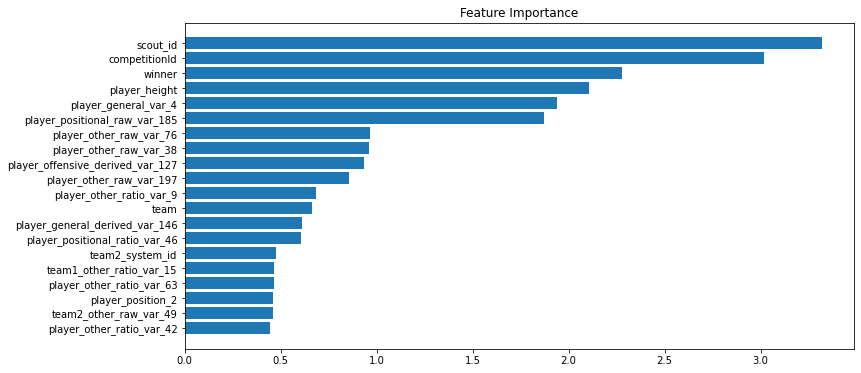

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_test.columns)[sorted_idx])
plt.title('Feature Importance')

In [19]:
min(test_pred),max(test_pred),test_pred.mean()

(2.0430309026795967, 9.911779202170134, 6.478576922855297)

# 2nd Model -  LGBM with encoding of catagorical variables.

In [20]:
x_train = all2.iloc[0:20453,:]
x_test = all2.iloc[20453:,:]

x_train.shape , x_test.shape

((20453, 867), (8774, 867))

In [21]:
# This is my custom function for LGBM , i used it to get the best parameters

def lgbm_reg(x_train,y_train,x_test,n=10,cv=10,
                learning_rate=[0.01,0.05,0.1,0.3,0.5],
                max_depth= [2,4,6,8,10,12],
                num_leaves= [25,50,100,200],
                reg_lambda=[0.8], 
                reg_alpha=[0.8],
                n_estimators=[50,100,200,500,1000],
                subsample_freq=[1,2,3,4]):

    from sklearn.model_selection import RandomizedSearchCV

    import warnings

    import lightgbm as lgbm

    warnings.filterwarnings('ignore')

    from sklearn.pipeline import Pipeline,FeatureUnion
    from sklearn.base import BaseEstimator, TransformerMixin
    
    def report(results, n_top=3):
        for i in range(1, n_top + 1):
            candidates = np.flatnonzero(results['rank_test_score'] == i)
            for candidate in candidates:
                print("Model with rank: {0}".format(i))
                print("Mean validation score: {0:.3f} (std: {1:.5f})".format(
                      results['mean_test_score'][candidate],
                      results['std_test_score'][candidate]))
                print("Parameters: {0}".format(results['params'][candidate]))
                print("")    
    
    
    lgbm_params = {  
                "learning_rate":learning_rate,
                "max_depth":max_depth,
                "num_leaves":num_leaves,
                "n_estimators":n_estimators,
                "reg_lambda":reg_lambda,
                "reg_alpha":reg_alpha,
                "subsample_freq":subsample_freq,
                #"metric":'rmse'
             }
    
    
    lgbm=lgbm.LGBMRegressor()
    n_iter=n

    random_search=RandomizedSearchCV(lgbm,n_jobs=-1,cv=cv,n_iter=n,scoring='r2',
                                 param_distributions=lgbm_params)
    random_search.fit(x_train,y_train)
    report(random_search.cv_results_,5)
    test_pred= random_search.predict(x_test)
    test_pred=test_pred.reshape(len(test_pred),1)
    return(test_pred)    

In [ ]:
# Replace with best parameters combination and predict 
import time
start_time = time.time()
lgbm_pred = lgbm_reg(x_train,y_train,
                    x_test,cv=3,n=1,
                   n_estimators=[1000],learning_rate=[0.05],
                   subsample_freq=[2],num_leaves=[100],
                     max_depth=[8],
                    )

ss['rating_num'] = lgbm_pred
#ss.to_csv('football2.csv',index=False)
print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:
min(lgbm_pred),max(lgbm_pred),lgbm_pred.mean()

In [ ]:
lgbm_pred[lgbm_pred>10]=10
min(lgbm_pred),max(lgbm_pred),lgbm_pred.mean()

# Take average of both the models

In [ ]:
ss['rating_num'] = test_pred.reshape(8774,1)*0.5 + lgbm_pred*0.5
min(ss['rating_num']),max(ss['rating_num']),ss['rating_num'].mean()

# Explore Rating Distributions

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
train = pd.read_csv("C:\\Users\\chakr\\Downloads\\train_1K0BDt5\\train.csv")

train.rating_num.plot.density(color='green')
plt.title('Density plot for Speeding')
plt.show()

train['rating_num'].value_counts()

####  Even after taking the average of both the models the minimum is still 1.42 , which should be closer to zero. I tried with dropping few rows of training data with Rating 10 and got better score. which proves that the result is getting baised towards higher rating. Eventually i found the below method to reduce that biasness. I started with -1.4 ( minimum of my prediction was -1.42) and gradually changed it with different section. Rating between 5 to 7.5 are treated more finely due to presence of higher number of predictions. Just like parameter tuning had to perform plenty of trial and errors to get what is working best.

In [ ]:
ss['rating_num'] = (test_pred.reshape(8774,1)*0.5 + lgbm_pred*0.5)
ss['rating_num'][ss['rating_num']<2]= ss['rating_num'] -1.4
ss['rating_num'][(ss['rating_num']<4) & (ss['rating_num']>=2)]= ss['rating_num']-1.3
ss['rating_num'][(ss['rating_num']<5) & (ss['rating_num']>=4)]= ss['rating_num']-1
ss['rating_num'][(ss['rating_num']<5.25) & (ss['rating_num']>=5)]= ss['rating_num']-0.85
ss['rating_num'][(ss['rating_num']<5.5) & (ss['rating_num']>=5.25)]= ss['rating_num']-0.67
ss['rating_num'][(ss['rating_num']<5.75) & (ss['rating_num']>=5.5)]= ss['rating_num']-0.55
ss['rating_num'][(ss['rating_num']<6) & (ss['rating_num']>=5.75)]= ss['rating_num']-0.42
ss['rating_num'][(ss['rating_num']<6.25) & (ss['rating_num']>=6)]= ss['rating_num']-0.41
ss['rating_num'][(ss['rating_num']<6.5) & (ss['rating_num']>=6.25)]= ss['rating_num']-0.52
ss['rating_num'][(ss['rating_num']<6.75) & (ss['rating_num']>=6.5)]= ss['rating_num']-0.46
ss['rating_num'][(ss['rating_num']<7) & (ss['rating_num']>=6.75)]= ss['rating_num']-0.36
ss['rating_num'][(ss['rating_num']<7.25) & (ss['rating_num']>=7)]= ss['rating_num']-0.40
ss['rating_num'][(ss['rating_num']<7.5) & (ss['rating_num']>=7.25)]= ss['rating_num']-0.54
ss['rating_num'][(ss['rating_num']<8) & (ss['rating_num']>=7.5)]= ss['rating_num']-0.15
ss['rating_num'][(ss['rating_num']<8.5) & (ss['rating_num']>=8)]= ss['rating_num']-0.10
ss['rating_num'][(ss['rating_num']<9) & (ss['rating_num']>=8.5)]= ss['rating_num']-0.20
ss['rating_num'][(ss['rating_num']<11) & (ss['rating_num']>=9)]= ss['rating_num']-0.12


In [ ]:
ss.to_csv('football2.csv',index=False)